# DNA and RNA Data Multi Class Single Label  with IQR boundries
By Brandon Khuu
Last update: 5/10/2021

### Goal
Create a multi-class single label classification neural network with mRNA read data(FPKM).
The classes being classfied are Control(patient is not Autistic), 15q duplication(patient is Autistic), and 16p11 deletion(patient is autisitc)

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the data

Import the raw RNA data. The indexes are the genes. The header row are the different samples.

In [2]:
#import  raw data data
rna = pd.read_csv('Organoid Files/all_autism_fpkm.csv', header=0, low_memory=False)
rna.head()

,Unnamed: 0,PGP1-1,PGP1-2,PGP1-3,GM23716-1,GM23716-2,GM23716-3,GM23720-1,GM23720-2,GM23720-3,...,14739x3-2,14765x2-1,14765x2-2,14765x2-3,14710x6-1,14781x16-1,14781x16-2,14781x16-3,14746x8-1,14746x8-2
0,CDK5RAP1,5.561823,2.050032,2.481599,4.396121,3.721746,2.260565,3.482430,3.136405,4.645353,...,6.594048,6.941136,7.453001,3.405732,2.784555,6.384259,3.128289,7.880060,3.388043,3.623195
1,TMEM246,9.167399,6.121957,14.205795,15.263531,14.125613,6.008471,5.544019,5.302956,7.467318,...,3.478945,4.855474,4.652040,7.574598,6.334495,7.771520,8.186893,4.857521,3.334954,6.834265
2,PKD1,4.762467,3.086031,8.663784,8.198981,10.278191,5.577455,4.226272,4.628730,7.837992,...,8.564923,6.328464,3.316495,16.091198,9.193670,7.071175,9.025883,7.076191,10.996357,3.154569
3,EDEM1,4.259699,3.888580,2.988719,3.433083,3.331196,3.524835,3.539229,3.586650,3.683216,...,5.435888,6.711067,5.737995,2.197396,2.511982,3.297171,4.009783,4.097137,1.545692,3.818004
4,LSM11,3.333153,3.064389,13.747564,13.873706,13.211928,2.783226,3.232596,3.103675,4.635612,...,2.875419,3.106984,2.572676,2.553229,3.452511,5.224131,4.728078,5.166222,1.109277,3.262106


## Data Preprocessing

### Apply Threshold for FPKM reads
-Get the mean for each gene<br>
-Remove genes that fall below the minimum threshold

In [3]:
#get index col for later
gene_names = rna['Unnamed: 0']

#remove gene name col
rna = rna.drop('Unnamed: 0', axis=1)

#create Mean column
rna['Mean'] = rna.mean(axis=1)

#create genes to drop
genes_to_drop = [i for i in range(rna.shape[0]) if rna.Mean[i] <= 2]

#drop columns
rna = rna.drop(genes_to_drop)
rna = rna.drop('Mean', axis=1)

#adjust gene list
for i in genes_to_drop:
    gene_names = gene_names.drop(i)

#Set Index
rna['Sample'] = gene_names
rna = rna.set_index('Sample')
rna = rna.T
rna.head()

Sample,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,MRPS33,COPS8,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
PGP1-1,5.561823,9.167399,4.762467,4.259699,3.333153,5.245319,15.288924,10.670947,15.418737,26.492518,...,36.320081,23.422699,6.506580,7.639236,1.808342,253.147425,2.624415,5.473228,9.892221,14.017985
PGP1-2,2.050032,6.121957,3.086031,3.888580,3.064389,4.530108,14.225061,11.109630,21.596005,23.446239,...,19.707959,12.679506,6.687741,7.457054,1.614225,290.182382,3.276070,7.483068,7.377414,11.613564
PGP1-3,2.481599,14.205795,8.663784,2.988719,13.747564,6.189141,18.021990,15.850792,9.871680,32.272768,...,15.002978,9.314311,6.744241,36.158595,3.626686,118.126815,2.221963,5.087976,2.392554,15.666102
GM23716-1,4.396121,15.263531,8.198981,3.433083,13.873706,5.018456,17.714552,15.832140,4.594193,30.869273,...,13.609106,9.826147,6.570986,32.786094,3.988325,103.634970,2.459700,4.626596,2.301205,16.500382
GM23716-2,3.721746,14.125613,10.278191,3.331196,13.211928,5.620373,15.806883,15.434513,7.544800,24.221830,...,13.346974,4.147004,5.990253,55.245293,3.849378,111.978695,2.494851,4.843815,2.285043,18.534124


# Remove outliers

Find and remove outliers using Interquartile upper bound

In [4]:
#Get description of data frame
rna_description = rna.describe()
rna_description

Sample,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,MRPS33,COPS8,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,...,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,4.251091,6.086961,6.339876,3.889167,3.776967,6.669858,10.786037,9.214780,14.900356,21.712939,...,18.297158,24.368090,4.830248,26.456523,2.869627,322.669800,2.539877,4.227956,5.871224,13.825605
std,1.552523,2.682573,2.993639,1.714649,2.419474,3.274987,3.707618,2.754342,6.142619,5.574753,...,8.266908,14.571598,1.818987,12.773020,0.785765,117.609148,0.815381,1.348172,2.307261,3.753525
min,1.642499,0.737503,1.373917,1.248757,1.109277,1.080013,3.361271,2.709484,4.326904,9.226015,...,6.120197,0.035749,1.403382,7.450906,1.318897,93.281158,0.819236,1.359497,1.798324,3.886283
25%,3.161636,4.813943,4.110742,3.015643,2.524728,5.057375,8.755803,7.814825,10.026822,19.559559,...,12.532685,12.706315,3.499003,18.610024,2.267118,263.567587,2.007624,3.301800,3.924975,11.386199
50%,4.102123,5.909210,6.178350,3.693254,3.106984,5.753606,10.602403,9.530601,15.258703,22.095454,...,16.674666,23.422699,4.672878,24.529242,2.825838,319.538125,2.577606,4.334588,6.071386,14.017985
75%,5.019582,7.549392,8.110570,4.456003,4.244263,7.551983,12.823286,10.599152,18.642767,24.835660,...,22.618437,29.896202,6.130695,30.623387,3.302059,394.065874,3.054825,5.066565,7.564706,16.364320
max,8.803148,15.263531,16.091198,11.888391,13.873706,17.226045,21.528132,15.850792,30.976296,42.479591,...,54.222988,63.285407,13.099090,69.826664,5.200346,584.605959,4.930689,7.483068,10.173363,22.703151


## Create upper bound
Create an upper bound to filter out outlier genes

In [5]:
#creat IQR
IQR = (rna_description.loc['75%'] - rna_description.loc['25%'])
IQR = IQR*1.5
upper_bound = rna_description.loc['75%'] + IQR
upper_bound

Sample
CDK5RAP1      7.806501
TMEM246      11.652564
PKD1         14.110312
EDEM1         6.616542
LSM11         6.823566
               ...    
GSTP1       589.813305
IPP           4.625628
ASB3          7.713712
EHD4         13.024304
NRSN2        23.831500
Length: 11271, dtype: float64

In [6]:
#Apply IQR filter
IQR_drop_list = []
for i in rna.columns:
    temp = rna.get(i)
    for j in range(temp.shape[0]):
        if temp[j] > upper_bound[i]:
            IQR_drop_list.append(j)

            
#create filter list
IQR_drop_list.sort()
IQR_drop_set = set(IQR_drop_list)
col_to_drop = [rna.columns[i] for i in IQR_drop_set]

#drop columns
rna = rna.drop(col_to_drop, axis=1)
rna.head()

Sample,HSBP1,CAP1,ZFHX4-AS1,FBXL7,PMPCA,PHF12,MGST3,LOC283070,PPP1R12B,DDX47,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
PGP1-1,84.510038,25.546087,3.243708,5.533667,16.558363,6.716821,36.765727,3.525942,2.870405,16.862604,...,36.320081,23.422699,6.506580,7.639236,1.808342,253.147425,2.624415,5.473228,9.892221,14.017985
PGP1-2,75.044515,20.451054,3.015391,6.885036,12.673928,5.882669,27.229725,2.658576,2.758019,21.509196,...,19.707959,12.679506,6.687741,7.457054,1.614225,290.182382,3.276070,7.483068,7.377414,11.613564
PGP1-3,100.825429,24.200828,1.594495,1.653018,12.994339,5.947767,46.156174,5.883554,3.761642,13.479399,...,15.002978,9.314311,6.744241,36.158595,3.626686,118.126815,2.221963,5.087976,2.392554,15.666102
GM23716-1,92.587682,22.887937,2.100904,1.835257,11.945566,5.041255,40.480850,6.950511,3.762403,13.463209,...,13.609106,9.826147,6.570986,32.786094,3.988325,103.634970,2.459700,4.626596,2.301205,16.500382
GM23716-2,77.996502,22.323798,1.744930,1.764977,12.519729,6.163550,38.602007,6.977038,3.790913,14.215236,...,13.346974,4.147004,5.990253,55.245293,3.849378,111.978695,2.494851,4.843815,2.285043,18.534124


## Import DNA data

Import the DNA data. The sample's VCF data were merged into a csv file. <br>
The SNPs were filtered to be the same across chromesome/positions.<br>

In [7]:
csv_lst = ['VCFs/chrm_split/chr1_replicates.csv', 'VCFs/chrm_split/chr2_replicates.csv','VCFs/chrm_split/chr3_replicates.csv','VCFs/chrm_split/chr4_replicates.csv','VCFs/chrm_split/chr5_replicates.csv',
'VCFs/chrm_split/chr6_replicates.csv','VCFs/chrm_split/chr7_replicates.csv','VCFs/chrm_split/chr8_replicates.csv','VCFs/chrm_split/chr9_replicates.csv','VCFs/chrm_split/chr10_replicates.csv',
'VCFs/chrm_split/chr11_replicates.csv','VCFs/chrm_split/chr12_replicates.csv','VCFs/chrm_split/chr13_replicates.csv','VCFs/chrm_split/chr14_replicates.csv','VCFs/chrm_split/chr15_replicates.csv',
'VCFs/chrm_split/chr16_replicates.csv','VCFs/chrm_split/chr17_replicates.csv','VCFs/chrm_split/chr18_replicates.csv','VCFs/chrm_split/chr19_replicates.csv','VCFs/chrm_split/chr20_replicates.csv',
'VCFs/chrm_split/chr21_replicates.csv','VCFs/chrm_split/chr22_replicates.csv','VCFs/chrm_split/chrX_replicates.csv','VCFs/chrm_split/chrY_replicates.csv']

def storage_lst(file_lst):
    lst = []
    for i in file_lst:
        df = pd.read_csv(i, header=0)
        df = df.drop('Unnamed: 0', axis=1)
        lst.append(df)  
    return lst

df_list = storage_lst(csv_lst)

dna = pd.concat(df_list,ignore_index=True)
dna.head()

#create col header for transposed dna dataframe
chrmPos = []
for i in range(dna.shape[0]):
    s = str(dna.CHROM[i]) + '@' + str(dna.POS[i])
    chrmPos.append(s)
    
#append to dataframe and prep for analysis
dna.insert(loc=0, column='Samples', value=chrmPos)
dna.rename(columns={'14858x3-3': '14758x3-3','14858x3-2': '14758x3-2','14858x3-1': '14758x3-1'},inplace=True)
dna = dna.drop(['CHROM','POS'], axis=1)
dna = dna.set_index('Samples')
dna = dna.T
display(dna.head())

Samples,chr1@69511,chr1@762273,chr1@782981,chr1@792263,chr1@792480,chr1@866319,chr1@879676,chr1@879687,chr1@880238,chr1@881627,...,chrY@14107068,chrY@16835007,chrY@15024588,chrY@15021522,chrY@15026658,chrY@21894633,chrY@13309418,chrY@14832620,chrY@5491186,chrY@24457719
PGP1-3,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Reference,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
PGP1-2,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Reference,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
GM25256-3,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Homozygous Reference,Homozygous Alternate,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Alternate,Homozygous Reference,Homozygous Reference
GM25256-2,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Homozygous Reference,Homozygous Alternate,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Alternate,Homozygous Reference,Homozygous Reference
GM23720-3,Homozygous Alternate,Homozygous Alternate,Homozygous Reference,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Heterozygous Alternate,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Alternate,Homozygous Reference


## Label Encoder

Convert the categorical string VCF data to an encoded factor<br>
Homozygous Reference<br>
Homozygous Alternative<br>
Homozygous Alternative2<br>
Heterozygous Alternative<br>
Heterozygou Alternative2<b2>

In [8]:
#encode data
reference_dict = {'Homozygous Reference':0, 'Heterozygous Alternate':1, 
					'Heterozygous Alternate 1/2':2,'Homozygous Alternate':3}

dna = dna.replace(reference_dict)
display(dna.head())

Samples,chr1@69511,chr1@762273,chr1@782981,chr1@792263,chr1@792480,chr1@866319,chr1@879676,chr1@879687,chr1@880238,chr1@881627,...,chrY@14107068,chrY@16835007,chrY@15024588,chrY@15021522,chrY@15026658,chrY@21894633,chrY@13309418,chrY@14832620,chrY@5491186,chrY@24457719
PGP1-3,3,1,1,1,3,0,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
PGP1-2,3,1,1,1,3,0,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
GM25256-3,3,1,1,3,3,3,3,3,3,3,...,0,3,0,0,0,0,0,3,0,0
GM25256-2,3,1,1,3,3,3,3,3,3,3,...,0,3,0,0,0,0,0,3,0,0
GM23720-3,3,3,0,3,3,3,3,3,3,1,...,0,0,0,0,0,0,0,0,3,0


## Merge the two datasets

Merge the RNA and DNA datasets using the samples as the index

In [9]:
df = rna.merge(dna, how='left', left_index=True, right_index=True)
df

,HSBP1,CAP1,ZFHX4-AS1,FBXL7,PMPCA,PHF12,MGST3,LOC283070,PPP1R12B,DDX47,...,chrY@14107068,chrY@16835007,chrY@15024588,chrY@15021522,chrY@15026658,chrY@21894633,chrY@13309418,chrY@14832620,chrY@5491186,chrY@24457719
PGP1-1,84.510038,25.546087,3.243708,5.533667,16.558363,6.716821,36.765727,3.525942,2.870405,16.862604,...,0,0,0,0,0,0,0,0,0,0
PGP1-2,75.044515,20.451054,3.015391,6.885036,12.673928,5.882669,27.229725,2.658576,2.758019,21.509196,...,0,0,0,0,0,0,0,0,0,0
PGP1-3,100.825429,24.200828,1.594495,1.653018,12.994339,5.947767,46.156174,5.883554,3.761642,13.479399,...,0,0,0,0,0,0,0,0,0,0
GM23716-1,92.587682,22.887937,2.100904,1.835257,11.945566,5.041255,40.480850,6.950511,3.762403,13.463209,...,0,0,0,0,0,0,0,0,0,0
GM23716-2,77.996502,22.323798,1.744930,1.764977,12.519729,6.163550,38.602007,6.977038,3.790913,14.215236,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14781x16-1,59.519577,18.980672,0.701874,2.534477,9.222742,5.545906,27.994829,9.080746,4.319379,16.171127,...,0,0,0,0,0,0,0,0,1,0
14781x16-2,49.486703,14.213706,0.255896,3.281960,8.749251,6.342409,22.763812,10.757855,4.058539,13.042867,...,0,0,0,0,0,0,0,0,1,0
14781x16-3,72.110648,26.589330,1.757771,3.108920,12.791239,6.868103,24.011117,6.961321,3.513819,18.343377,...,0,0,0,0,0,0,0,0,1,0
14746x8-1,32.111065,8.007251,1.232853,3.586426,8.646967,3.758523,38.059598,2.645508,1.038739,5.965622,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#create target column
autism = []
for i in range(71):
    if i > 47:
        autism.append(2.0)
    elif i > 35:
        autism.append(1.0)
    else: 
        autism.append(0.0)
autism = np.asarray(autism)
autism

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

In [54]:
#split train/test samples

x_test = df.iloc[[36,48]]
y_test = autism[[36,48]]

x_train = df.drop(['1601-3','1601-2','1601-1','14758x3-1','14758x3-2','14758x3-3'],
                  axis=0)
y_train = np.delete(autism,[36,37,38,48,49,50])

## Split data set into train and testing 
Import train_test_split and split data into training and testing sets with testing size set to 1/3

Model Accuracy: 0.0
|--- chr21@34624386 <= 1.50
|   |--- class: 0.0
|--- chr21@34624386 >  1.50
|   |--- chr3@190594452 <= 0.50
|   |   |--- class: 2.0
|   |--- chr3@190594452 >  0.50
|   |   |--- chr19@51413802 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- chr19@51413802 >  0.50
|   |   |   |--- class: 1.0

Model Accuracy: 0.0
|--- chr21@34624386 <= 1.50
|   |--- class: 0.0
|--- chr21@34624386 >  1.50
|   |--- chr8@139727811 <= 0.50
|   |   |--- chr2@43919934 <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- chr2@43919934 >  0.50
|   |   |   |--- class: 0.0
|   |--- chr8@139727811 >  0.50
|   |   |--- class: 2.0

Model Accuracy: 0.0
|--- chr21@34624386 <= 1.50
|   |--- class: 0.0
|--- chr21@34624386 >  1.50
|   |--- chr5@179554602 <= 0.50
|   |   |--- class: 2.0
|   |--- chr5@179554602 >  0.50
|   |   |--- chr17@18186266 <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- chr17@18186266 >  0.50
|   |   |   |--- class: 0.0

Model Accuracy: 0.0
|--- chr21@34624386 <= 1.50
|   |--- class:

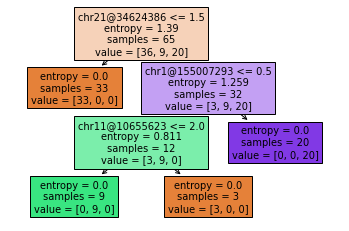

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from random import *

rand_state =[]
acc = []
for j in range(5):
    feature_names=[i for i in df.columns]

    random_state = randint(1,100)
    rand_state.append(random_state)
    
    tree = DecisionTreeClassifier(criterion='entropy',random_state=random_state)
    tree.fit(x_train,y_train)
    tree_prediction = tree.predict(x_test)

    tree_accuracy = accuracy_score(y_test, tree_prediction)
    acc.append(tree_accuracy)
    print('Model Accuracy: {}'.format(tree_accuracy*100))
    plot_tree(tree,feature_names=feature_names,filled=True)
    print(export_text(tree, feature_names=feature_names))
    s = 'tree'+ str(random_state) + '.dot'
    #export_graphviz(tree,out_file=s, feature_names=feature_names, filled=True)

print(rand_state)
print(acc)

Iteration 1, loss = 16.09127181
Iteration 2, loss = 24.95346970
Iteration 3, loss = 31.05318121
Iteration 4, loss = 31.05320065
Iteration 5, loss = 29.28432906
Iteration 6, loss = 21.70664103
Iteration 7, loss = 5.31502836
Iteration 8, loss = 8.29004094
Iteration 9, loss = 12.19655543
Iteration 10, loss = 8.82748374
Iteration 11, loss = 4.99111060
Iteration 12, loss = 4.99113918
Iteration 13, loss = 4.99117188
Iteration 14, loss = 5.12749146
Iteration 15, loss = 5.83951381
Iteration 16, loss = 5.89476823
Iteration 17, loss = 5.24922826
Iteration 18, loss = 4.99131055
Iteration 19, loss = 4.99133359
Iteration 20, loss = 4.99135513
Iteration 21, loss = 4.99137525
Iteration 22, loss = 4.99139404
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Model Accuracy: 0.0
[0. 0.]


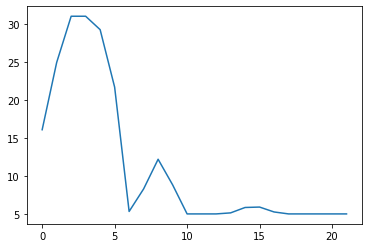

In [64]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(alpha=0.0001,max_iter=100, shuffle=True,
                   random_state=0,verbose = True, validation_fraction=0.01)
nn.fit(x_train,y_train)
nn_prediction= nn.predict(x_test)

nn_accuracy = accuracy_score(y_test, nn_prediction)

print('Model Accuracy: {}'.format(nn_accuracy*100))
print(nn_prediction)
plt.plot(nn.loss_curve_)

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(x_train, y_train)
rf_prediction = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_prediction.round())
print('Model Accuracy: {}'.format(rf_accuracy*100))

Model Accuracy: 0.0
